In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras # Yapay Sinir Ağları kütüphanesi
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization # YSA Katmanları
from keras.preprocessing.image import ImageDataGenerator # Veri arttırma
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e) # Hataları görmezden gel.
    return np.array(data)

In [4]:
train = get_training_data('/content/drive/MyDrive/archive/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/archive/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/archive/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


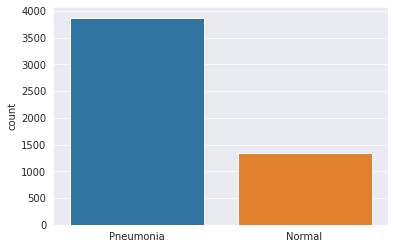

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


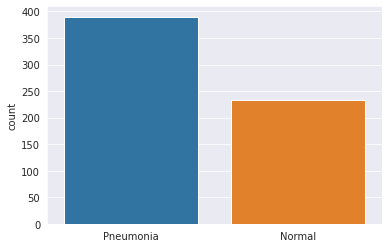

In [6]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


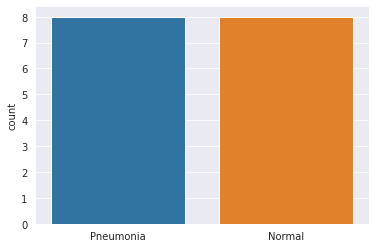

In [7]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'PNEUMONIA')

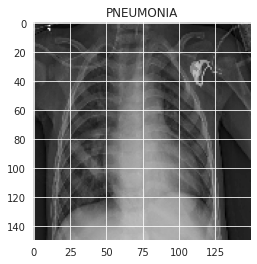

In [ ]:
# İki sınıftan da örnek resim
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'NORMAL')

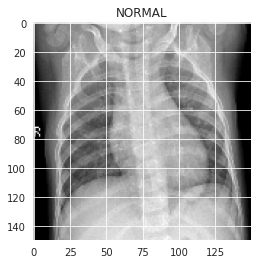

In [ ]:
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for feature, label in train:
  X_train.append(feature)
  y_train.append(label)

for feature, label in test:
  X_test.append(feature)
  y_test.append(label)
  
for feature, label in val:
  X_val.append(feature)
  y_val.append(label)

In [9]:
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [10]:
X_train= X_train.reshape(-1, img_size, img_size, 1)
X_test=X_test.reshape(-1, img_size, img_size, 1)
X_val= X_val.reshape(-1, img_size, img_size, 1)

In [11]:
X_train.shape

(5216, 150, 150, 1)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 30, # Bazı rastgele resimleri 30 derece döndür.
        zoom_range = 0.2, # Bazı rastgele resimleri 0.2 derece yakınlaştır.
        width_shift_range=0.1,  # Bazı rastgele resimleri 0.1 oranında sağa veya sola kaydır.
        height_shift_range=0.1,  # Bazı rastgele resimleri 0.1 oranında dikey kaydır.
        horizontal_flip = True,  # Bazı rastgele resimlerin ayna görüntüsünü al.
        )
datagen.fit(X_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 293s 2s/step - loss: 0.5990 - accuracy: 0.8365 - val_loss: 28.1298 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 291s 2s/step - loss: 0.2786 - accuracy: 0.8924 - val_loss: 47.6250 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9206
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 290s 2s/step - loss: 0.2156 - accuracy: 0.9206 - val_loss: 16.7770 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 290s 2s/step - loss: 0.1525 - accuracy: 0.9461 - val_loss: 3.1819 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9482
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===================

In [ ]:
print("Loss: " , model.evaluate(X_test,y_test)[0])
print("Accuracy: " , model.evaluate(X_test,y_test)[1]*100)

20/20 [==============================] - 7s 355ms/step - loss: 0.3935 - accuracy: 0.9071
Loss:  0.3934544324874878
20/20 [==============================] - 7s 353ms/step - loss: 0.3935 - accuracy: 0.9071
Accuracy:  90.70512652397156


In [ ]:
model.save('/content/drive/MyDrive/Belgeler/Bitirme/Zaturre_Tespit_Model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Belgeler/Bitirme/Zaturre_Tespit_Model/assets


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Belgeler/Bitirme/Zaturre_Tespit_Model')

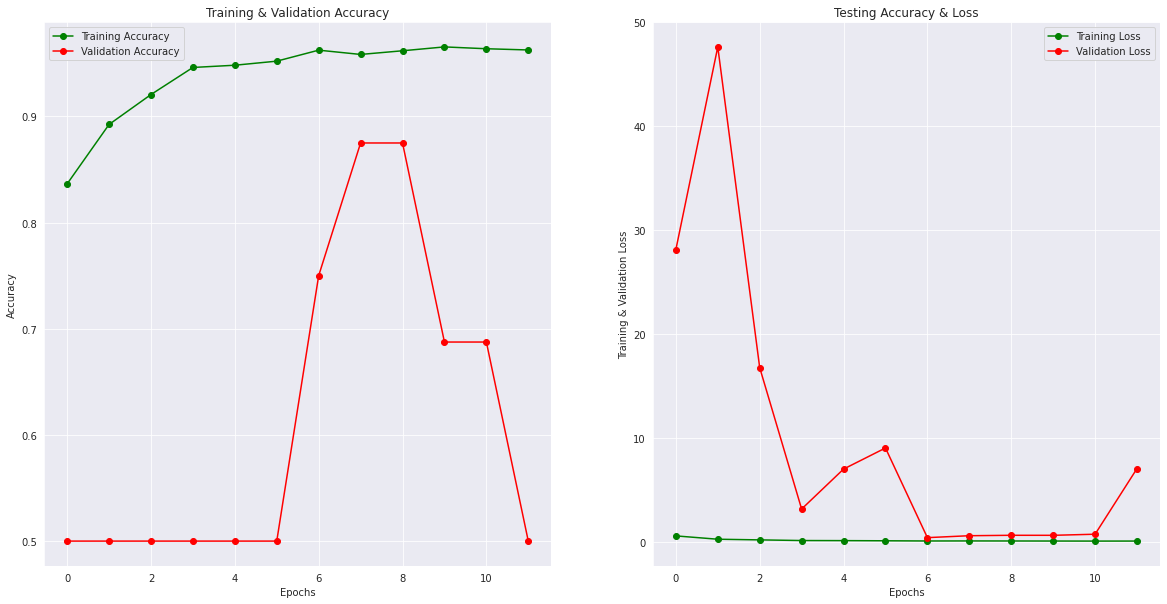

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names=['Pneumonia', 'Healthy']))

              precision    recall  f1-score   support

   Pneumonia       0.90      0.96      0.93       390
     Healthy       0.92      0.82      0.87       234

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
cm = confusion_matrix(y_test, predictions)

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

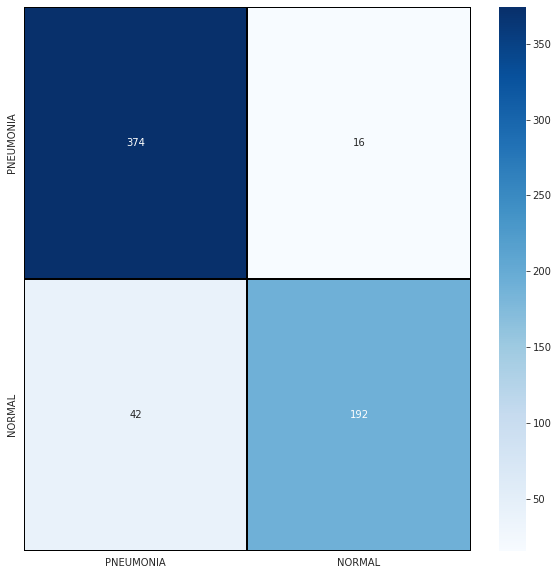

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

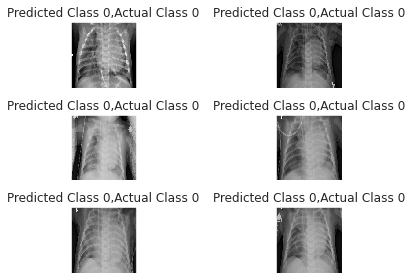

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

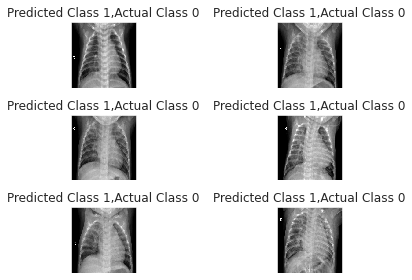

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1